In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
maze = np.array([[1,0,2,2,2,2,2,2,2,2,2,2,2,2,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,2,2,2,2,2,2,2,2,2,2,2,2,0],
                [0,0,2,2,2,2,2,2,2,2,2,2,2,2,0],
                [0,0,2,2,2,2,2,2,2,2,2,2,2,2,0],
                [0,0,2,2,2,2,2,2,2,2,2,2,2,2,0],
                [0,0,2,2,2,2,2,2,2,2,2,2,2,2,0],
                [0,0,2,2,2,2,2,2,2,2,2,2,2,2,3],
                [0,0,2,2,2,2,2,2,2,2,2,2,2,2,0],
                [0,0,2,2,2,2,2,2,2,2,2,2,2,2,0],
                [0,0,2,2,2,2,2,2,2,2,2,2,2,2,0],
                [0,0,2,2,2,2,2,2,2,2,2,2,2,2,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0],
                [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]])
n, _ = maze.shape

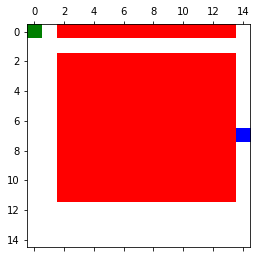

In [2]:
cmap = ListedColormap(['w', 'g', 'r', 'b'])
plt.matshow(maze, cmap = cmap)

In [74]:
class Maze:
    def __init__(self, maze, L = -20, R = 1000, G = -2, C = -2, alpha = 0.2, 
                 gamma = 0.9, beta = 1, beta_inc = 0.01, p = 0.014):
        self.counter = 10
        self.num = 4
        self.alpha = alpha
        self.gamma = gamma
        self.beta = beta
        self.beta_inc = beta_inc
        self.p = p
        self.C = C
        self.L = L
        self.G = G
        self.R = R
        self.maze = maze
        n, _ = maze.shape
        self.n = n
        self.Q = np.zeros((n, n, self.num), dtype = np.float32)
        self.Q_action = np.zeros(self.num)
        self.Q_action_n = np.zeros(self.num)
        self.coor = (0, 0)
        self.goal = (7, 14)
        self.reward_sum = 0
        
        
    def Reward(self, i, j):
        cell = self.maze[i][j]
        if cell == 0:
            return self.C
        elif cell == 1:
            return self.G
        elif cell == 2:
            return self.L
        elif cell == 3:
            return self.R
    
    def softmax(self, s, action, possible):
        i, j = s
        tmp = np.zeros(len(possible))
        for k in range(len(possible)):
            tmp[k] = np.exp(self.beta*self.Q[i][j][possible[k]])
        den = np.sum(tmp)
        num = np.exp(self.beta*self.Q[i][j][action])
        return num / den
    
    def next_action(self, possible):
        temp = np.zeros(len(possible))
        i, j = self.coor
        cnt = 0
        for act in possible:
            #temp[cnt] = self.softmax(self.coor, act, possible)
            temp[cnt] = self.Q[i][j][act]
            cnt += 1
        index = np.argmax(temp)
        return possible[index], index
    
    def is_edge(self, i, j):
        if i < 0 or j < 0 or i > self.n-1 or j > self.n-1:
            return True
        else:
            return False
        
    def update(self, s, s1, a, r):
        i1, j1 = s1
        i, j = s
        u = np.max(self.Q[i1][j1][:])
        self.Q[i][j][a] += self.alpha*(r + self.gamma * u - self.Q[i][j][a])
        
    def possible_actions(self, i, j):
        if (i>0) and (i<self.n - 1) and (j>0) and (j<self.n - 1):
            return [0,1,2,3]
        elif (i == 0):
            if (j == 0):
                return [0,3]
            elif (j == self.n - 1):
                return [2,3]
            else:
                return [0,2,3]
        elif (i == self.n - 1):
            if (j == 0):
                return [0,1]
            elif (j == self.n - 1):
                return [1,2]
            else:
                return [0,1,2]
        elif (j == 0):
            return [0,1,3]
        elif (j == self.n - 1):
            return [1,2,3]

    def next_state(self, p):
        s_old = self.coor
        i, j = self.coor
        possible = self.possible_actions(i, j)
        random = np.random.uniform(0,1,1)[0]
        #print(f"possible={possible}")
        #print(f"coor={self.coor}")
        action, index = self.next_action(np.asarray(possible))
        if random < p:
            arr = np.asarray(possible)
            np.delete(arr, index)
            action = np.random.choice(arr)
            #print(f"action of epsilon = {action}")

        #print(f"action={action}")
        if action == 0:
            j = j + 1
        elif action == 1:
            i = i - 1
        elif action == 2:
            j = j - 1
        elif action == 3:
            i = i + 1
        
        self.coor = (i, j)
            
        self.Q_action_n[action] += 1
        r = self.Reward(i, j)
        self.reward_sum += r
        self.Q_action[action] += (1/(self.Q_action_n[action]+1)) * (r - self.Q_action[action])
        self.update(s_old, self.coor, action, r)
        return action
            
            
    def one_round(self, p):
        m = 0
        path = ''
        while self.coor != self.goal:
            a = self.next_state(p)
            m += 1
            if a == 0:
                path += 'R'
            elif a == 1:
                path += 'U'
            elif a == 2:
                path += 'L'
            elif a == 3:
                path += 'D'
        return path, m
                
    def train(self, N):
        x = 100
        reward_ave = np.zeros(N)
        regret = np.zeros(N)
        self.Q = np.zeros((n, n, self.num), dtype = np.float32)
        self.Q_action = np.zeros(self.num)
        self.Q_action_n = np.zeros(self.num)
        self.coor = (0, 0)
        self.reward_sum = 0
        self.beta = 1

        self.coor = (0, 0)
        self.reward_sum = 0
        self.Q_action = np.zeros(self.num)
        self.Q_action_n = np.zeros(self.num)
        self.beta += self.beta_inc*self.beta
        for j in range(x):
            self.coor = (0, 0)
            self.reward_sum = 0
            path, m = self.one_round(0.5)
            regret[j] = 960 - self.reward_sum
            reward_ave[j] = self.reward_sum / m
            #print(m)
        for j in range(N - x):
            self.coor = (0, 0)
            self.reward_sum = 0
            path, m = self.one_round(self.p)
            regret[x + j] = 960 - self.reward_sum
            reward_ave[x + j] = self.reward_sum / m
            #print(m)
        #print(f"{m}, ")
            
        self.coor = (0, 0)
        self.reward_sum = 0
        path, m = self.one_round(self.p)
        regret[N-1] = 960 - self.reward_sum
        reward_ave[N-1] = self.reward_sum / m
        print(m)
        print(f"path = {path}\n")
        return reward_ave, regret

In [100]:
M = Maze(maze, p = 0.014)
reward_ave, regret = M.train(3000)
#print(M.Q)

21
path = RDRRRRRRRRRRRRRDDDDDD



In [101]:
M.reward_sum

960

In [102]:
reward_ave[-100:-1]

array([45.71428571, 45.71428571, 45.71428571, 45.71428571, 45.71428571,
       45.71428571, 45.71428571, 45.71428571, 45.71428571, 45.71428571,
       45.71428571, 45.71428571, 45.71428571, 45.71428571, 45.71428571,
       45.71428571, 45.71428571, 41.56521739, 45.71428571, 45.71428571,
       45.71428571, 45.71428571, 45.71428571, 45.71428571, 45.71428571,
       45.71428571, 45.71428571, 45.71428571, 45.71428571, 45.71428571,
       45.71428571, 40.7826087 , 45.71428571, 45.71428571, 45.71428571,
       45.71428571, 45.71428571, 45.71428571, 44.85714286, 44.85714286,
       45.71428571, 45.71428571, 45.71428571, 45.71428571, 45.71428571,
       45.71428571, 45.71428571, 45.71428571, 45.71428571, 45.71428571,
       45.71428571, 45.71428571, 45.71428571, 45.71428571, 45.71428571,
       45.71428571, 45.71428571, 45.71428571, 45.71428571, 45.71428571,
       45.71428571, 45.71428571, 45.71428571, 45.71428571, 45.71428571,
       45.71428571, 44.85714286, 45.71428571, 40.7826087 , 41.56

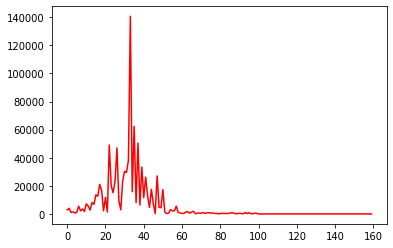

In [103]:
plt.plot(regret[0:160], 'r')

In [104]:
regret

array([2890., 4008., 1008., ...,    0.,    0.,    0.])